### __Short report__

In this notebook I train three models. 

<br>

#### Shallow ANN

This is two layered ANN with a ReLU activation function. This model achieves a maximum accuracy of 37.5%. 

<br>

#### CNN

This a deeper model with convolutions and a linear layer. The training data is random cropped to reduce overfitting of the model. The size of the cropped image didn't vary much from the resized image. This was done not to remove any facial features from the image. The highest accuracy achieved is 37.5%.  

I tried various architectures and different image transformations. It was difficult to make the model learn meaningful features. The random cropping of the image proved very important. 

<br>

#### CNN with face detection pipeline
The CNN model is pretty much the same as the first CNN model. The main difference is the data preperation. The images are cropped to only contain the face. This is done to make model focus on the important features of the image.

The face detection was done with a open source model from OpenCV. If the model detected a face in the image the image was cropped with safety margin. This was done to not to crop out parts of the face. For the images where the model didn't manage to detect any face, the image was just resized to to the same size as the other images in the data. 

The face detection reduced overfitting and increased the test accuracy. The model achieved an accuracy of 49.5%. Beating the second best model by 12%. The model could probably have been trained for longer to achieve even better results.  

<br>


### __Imports and unzip__

In [1]:
from google.colab import files
uploaded = files.upload()

Saving faces.zip to faces.zip


In [ ]:
!unzip published_dataset_129225401_1668770338627.zip

unzip:  cannot find or open published_dataset_129225401_1668770338627.zip, published_dataset_129225401_1668770338627.zip.zip or published_dataset_129225401_1668770338627.zip.ZIP.


In [ ]:
!unzip faces.zip

In [3]:
import os
import copy
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchvision.transforms import ToTensor, Resize, ToPILImage, RandomCrop

warnings.filterwarnings("ignore")
plt.ion()

### __Read and prep data__

In [4]:
rootdir = "published_dataset"
images = []

# the walk function iterates all the files and sub directories in the given
# directory. I use this to find all the image paths. 
for subdir, dirs, f in os.walk(rootdir):
  if subdir == 'faces': continue

  for subdir, dirs, f in os.walk(subdir):
    images.extend([f"{subdir}/{img}" for img in f])

In [5]:
# this maps target as string to int
target_str2int = {
    "heart" : 0,
    "oval" : 1,
    "round" : 2,
    "oblong" : 3,
    "square" : 4
}

# this maps target as int to string
target_int2str = {
    0: "heart",
    1: "oval",
    2 :"round" ,
    3 :"oblong",
    4 :"square"
}

# When we use pytorch we have to construct a dataset class with a __len__ method
# and a __getitem__ method. The __len__ method gives the length of the dataset.
# The __getitem__ method retrieves the image path, reads the image, performs any
# transform 
class Faceshapes(Dataset):
    """Faceshapes dataset."""

    def __init__(self, images, target_str2int = target_str2int, transform=None):
        # list with all the image paths
        self.images = images 
        # mapping of target as string to int
        self.target_str2int = target_str2int
        # transformations that will be used on 
        self.transform = transform

    def __len__(self):
      """This method returns the length of the dataset"""
      return len(self.images)

    def __getitem__(self, idx):
      """This method returns the image at index idx in the dataset after 
      applying transforms."""
      if torch.is_tensor(idx):
          idx = idx.tolist()

      img_name = self.images[idx]
      # the image is loaded 
      image = io.imread(img_name)
      # retrieving the target and encoding it as an integer
      shape = img_name.split("/")[1]
      shape_int = self.target_str2int[shape]
      # returns the sample as Dict[str, Any]
      sample = {'image': image, 'shape': shape_int}

      if self.transform:
          sample["image"] = self.transform(image)

      return sample

In [6]:
### Training and test data
test_imgs = np.random.choice(
    images, size=int(len(images) * .2), replace=False).tolist()

train_imgs = [img for img in images if img not in test_imgs]

### __Visualization__

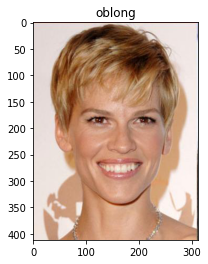

In [ ]:
# traing image
plt.imshow(io.imread(train_imgs[0]))
plt.title(train_imgs[0].split("/")[1])
plt.show()

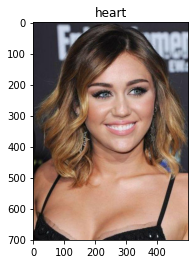

In [ ]:
# train image
plt.imshow(io.imread(train_imgs[100]))
plt.title(train_imgs[100].split("/")[1])
plt.show()

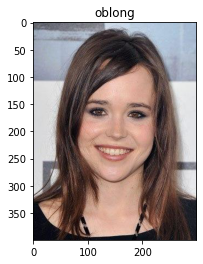

In [ ]:
# test image
plt.imshow(io.imread(test_imgs[50]))
plt.title(test_imgs[50].split("/")[1])
plt.show()

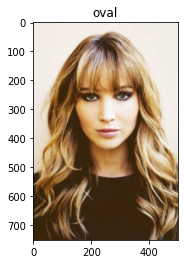

In [ ]:
# test image
plt.imshow(io.imread(test_imgs[25]))
plt.title(test_imgs[25].split("/")[1])
plt.show()

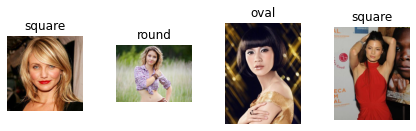

In [ ]:
# plotting random train images as grid
train_grid_faces = Faceshapes(train_imgs)

fig = plt.figure()
# make list of random indices
random_indices = random.sample(range(0, len(train_grid_faces)), 4)

# iterate list of random indices and plot 3 images 
for i, idx in enumerate(random_indices):
    sample = train_grid_faces[idx]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.axis('off')

    plt.imshow(sample["image"])
    plt.title(target_int2str[sample["shape"]])

    if i == 3:
        plt.show()
        break

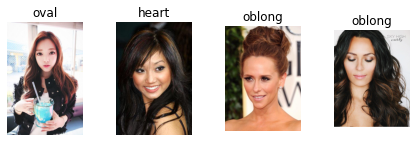

In [ ]:
# Plotting test images as grid
test_grid_faces = Faceshapes(test_imgs)

fig = plt.figure()
random_indices = random.sample(range(0, len(test_grid_faces)), 4)

for i, idx in enumerate(random_indices):
    sample = test_grid_faces[idx]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.axis('off')

    plt.imshow(sample["image"])
    plt.title(target_int2str[sample["shape"]])

    if i == 3:
        plt.show()
        break

### __Training functions__

In [7]:
def evaluate(model, val_loader):
  """Evaluates model with accuracy"""
  val_len = len(val_loader.dataset)
  model.eval()
  running_corr_preds = 0

  # iterate batches in val_loader
  for i, batch in enumerate(val_loader):
    y = batch["shape"].to(device)
    X = batch["image"].to(device).float()
    
    # calculate logits and get preds by retrieving the index of the largest
    # value in the logit vector
    logits = model(X)      
    _, preds = torch.max(logits, 1)
    running_corr_preds += torch.sum(preds == y.data)

  return running_corr_preds.double() / val_len

In [8]:
def training_loop(
  model, train_loader, val_loader, epochs, loss_fn,
  optimizer, scheduler = None):
  """This function defines the training loop for the models"""
  best_mod_weights = copy.deepcopy(model.state_dict())
  best_acc = 0
  loss_history = []
  val_history_train = []
  val_history = []
  train_len = len(train_loader.dataset)
  

  for e in range(1, epochs + 1):
      print(f'Epoch {e}/{epochs}')
      print('-' * 10)

      running_loss = 0
      running_corr_preds = 0

      model.train()
      for i, batch in enumerate(train_loader):
        y = batch["shape"].to(device)
        X = batch["image"].to(device).float()

        # clear grads
        optimizer.zero_grad()

        # compute prediction and loss. I use CrossEntropy loss as the
        # loss function so it's important that the model outsputs logits
        # and not preds. 
        logits = model(X) 
        loss = loss_fn(logits, y)

        # This is checking at what index the maximum logit is and sets 
        # the index with the highest value to the predicted value      
        _, preds = torch.max(logits, 1)

        # backpropagation
        loss.backward()
        optimizer.step()

        # loss * batch_size
        running_loss += loss.item() * X.shape[0]
        # this is summing up the number of correct preds at each iteration. 
        running_corr_preds += torch.sum(preds == y.data)

      # if theres a scheduler it's time to step, meaning adjust the learning
      # rate. 
      if scheduler:
        scheduler.step()

      # append running statistics to list to keep track of how the model is 
      # learning during training. 
      loss_history.append(running_loss/train_len)
      val_history_train.append(running_corr_preds.double() / train_len)

      # calculate current model accuracy and append to list
      epoch_acc = evaluate(model, val_loader)
      val_history.append(epoch_acc)

      # if current model acc is better than previous best model, make copy
      if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

      print(f'Training loss: {loss_history[-1]:.4f} Acc: {val_history_train[-1]:.4f}')
      print(f'Eval Acc: {val_history[-1]:.4f}')
      print()


  # when training is done, load the best model and return it
  model.load_state_dict(best_model_wts)
  return model, loss_history, val_history_train, val_history

### __Shallow ANN__

In [ ]:
# make training and test datasets and dataloaders
# The dimension of the images will be 160x160
test_ann = Faceshapes(
  test_imgs,
  transform = transforms.Compose(
    [
      ToPILImage(),
      Resize((160, 160)),
      ToTensor()
    ]
  )
)

train_ann = Faceshapes(
  train_imgs,
  transform = transforms.Compose(
    [
      ToPILImage(),
      Resize((160, 160)),
      ToTensor()
    ]
  )
)

# batch size of the test loader is equall to the length of the test dataset
test_dl_ann = DataLoader(
    test_ann, batch_size=len(test_imgs),
    shuffle=False, num_workers=0
)

# batch size is 24 for the training loader
train_dl_ann = DataLoader(
    train_ann, batch_size=24,
    shuffle=True, num_workers=0
)

In [ ]:
class ShallowANN(nn.Module):
  def __init__(self) -> None:
     super().__init__()
     self.flatten = nn.Flatten(start_dim=1)
     self.network = nn.Sequential(
         # input size is 160 x 160 x 3 since the image dimension is 160x160
         # and the pictures are RGB 
         nn.Linear(160 * 160 * 3, 12000),
         nn.ReLU(),
         nn.Linear(12000, 5),
     )

  def forward(self, x):
    x = self.flatten(x)
    preds = self.network(x)
    return preds 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = ShallowANN().to(device)

Using cuda device


In [ ]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model, loss_history, val_history_train, val_history = training_loop(
    model, train_dl_ann, test_dl_ann, 15, 
    loss_fn, optimizer, scheduler = None
)

Epoch 1/15
----------
Training loss: 111.2024 Acc: 0.2240
Eval Acc: 0.2050
Epoch 2/15
----------
Training loss: 2.2747 Acc: 0.3391
Eval Acc: 0.2900
Epoch 3/15
----------
Training loss: 1.6632 Acc: 0.4006
Eval Acc: 0.2750
Epoch 4/15
----------
Training loss: 1.3966 Acc: 0.4416
Eval Acc: 0.3100
Epoch 5/15
----------
Training loss: 1.2087 Acc: 0.5394
Eval Acc: 0.3000
Epoch 6/15
----------
Training loss: 1.1547 Acc: 0.5363
Eval Acc: 0.2650
Epoch 7/15
----------
Training loss: 1.0680 Acc: 0.5946
Eval Acc: 0.3350
Epoch 8/15
----------
Training loss: 0.9724 Acc: 0.6546
Eval Acc: 0.3100
Epoch 9/15
----------
Training loss: 0.8701 Acc: 0.6798
Eval Acc: 0.2950
Epoch 10/15
----------
Training loss: 0.7609 Acc: 0.7413
Eval Acc: 0.3200
Epoch 11/15
----------
Training loss: 0.7393 Acc: 0.7429
Eval Acc: 0.3500
Epoch 12/15
----------
Training loss: 0.7259 Acc: 0.7429
Eval Acc: 0.3600
Epoch 13/15
----------
Training loss: 0.6243 Acc: 0.8028
Eval Acc: 0.2900
Epoch 14/15
----------
Training loss: 0.5408 

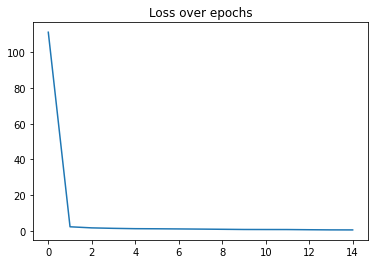

In [ ]:
plt.title("Loss over epochs")
plt.plot(loss_history)
plt.show()

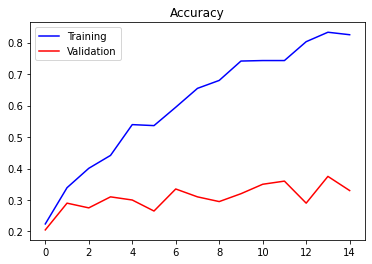

In [ ]:
plt.title("Accuracy")
plt.plot([v.cpu() for v in val_history_train], c="b", label="Training")
plt.plot([v.cpu() for v in val_history], c="r", label="Validation")
plt.legend()
plt.show()

### __CNN__

In [ ]:
# The images used for the cnn are slightly larger with a dim of 160x160.
test_cnn = Faceshapes(
  test_imgs,
  transform = transforms.Compose(
    [
      ToPILImage(),
      Resize((180, 180)),
      ToTensor()
    ]
  )
)

# The training images are random cropped from 220x220 to 180x180, this is done 
# so that the model wont overfit as much. 
train_cnn = Faceshapes(
  train_imgs,
  transform = transforms.Compose(
    [
      ToPILImage(),
      Resize((220, 220)),
      RandomCrop((180, 180)),
      ToTensor()
    ]
  )
)

test_dl_cnn = DataLoader(
    test_cnn, batch_size=len(test_imgs),
    shuffle=False, num_workers=0
)

train_dl_cnn = DataLoader(
    train_cnn, batch_size=24,
    shuffle=True, num_workers=0
)

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.flatten = nn.Flatten()

    self.conv = nn.Sequential(
        nn.Conv2d(
            in_channels = 3,
            out_channels = 32,
            kernel_size = (6,6)
        ), 
        nn.ReLU(),

        nn.MaxPool2d((2,2)), 

        nn.Conv2d(
            in_channels = 32, 
            out_channels = 16, 
            kernel_size = (6,6)
        ),
        
        nn.ReLU(),
    )

    self.linear = nn.Sequential(
        nn.Linear(
            in_features = 107584,
            out_features = 5,
        )
    )

  def forward(self, x):
    # first the data is passed through the conv layer: 
    # Conv->ReLu->MaxPool->Conv->ReLU
    # then the tensors are flattened and fed to the last linear layer. 
    x = self.conv(x)
    x = self.flatten(x)
    logits = self.linear(x)
    return logits

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = CNN().to(device)

Using cuda device


In [ ]:
learning_rate = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 30

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model, loss_history, val_history_train, val_history = training_loop(
    model, train_dl_cnn, test_dl_cnn, epochs, 
    loss_fn, optimizer, scheduler = None
)

Epoch 1/30
----------
Training loss: 1.6035 Acc: 0.2241
Eval Acc: 0.2650
Epoch 2/30
----------
Training loss: 1.5181 Acc: 0.3292
Eval Acc: 0.2950
Epoch 3/30
----------
Training loss: 1.4738 Acc: 0.3683
Eval Acc: 0.3000
Epoch 4/30
----------
Training loss: 1.4508 Acc: 0.3668
Eval Acc: 0.3100
Epoch 5/30
----------
Training loss: 1.4138 Acc: 0.4044
Eval Acc: 0.2950
Epoch 6/30
----------
Training loss: 1.3983 Acc: 0.4232
Eval Acc: 0.2750
Epoch 7/30
----------
Training loss: 1.3778 Acc: 0.4091
Eval Acc: 0.3350
Epoch 8/30
----------
Training loss: 1.3481 Acc: 0.4467
Eval Acc: 0.3250
Epoch 9/30
----------
Training loss: 1.3333 Acc: 0.4608
Eval Acc: 0.3200
Epoch 10/30
----------
Training loss: 1.2932 Acc: 0.4781
Eval Acc: 0.2950
Epoch 11/30
----------
Training loss: 1.2346 Acc: 0.5125
Eval Acc: 0.3000
Epoch 12/30
----------
Training loss: 1.2320 Acc: 0.5125
Eval Acc: 0.3050
Epoch 13/30
----------
Training loss: 1.2235 Acc: 0.5172
Eval Acc: 0.3350
Epoch 14/30
----------
Training loss: 1.2075 Ac

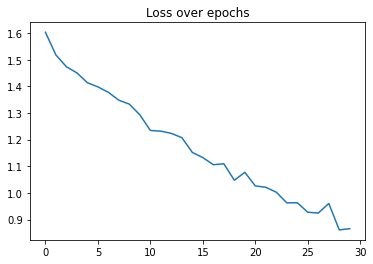

In [ ]:
plt.title("Loss over epochs")
plt.plot(loss_history)
plt.show()

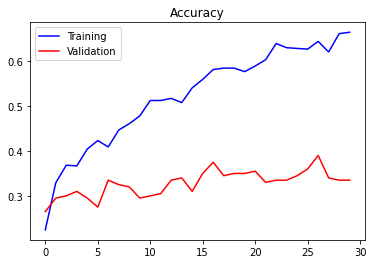

In [ ]:
plt.title("Accuracy")
plt.plot([v.cpu() for v in val_history_train], c="b", label="Training")
plt.plot([v.cpu() for v in val_history], c="r", label="Validation")
plt.legend()
plt.show()

In [ ]:
# saving model
torch.save(model.state_dict(), "./cnn_model.mod")

### __CNN combined with OpenCV face detection__

In [9]:
import cv2 as cv
from torchvision.transforms import Grayscale, Resize
# this is to show images if you use google colab
from google.colab.patches import cv2_imshow

In [10]:
# I have to import a xml file with a pretrained model from openCV.
# This model is used to find the faces in the image. 
cv2_base_dir = os.path.dirname(os.path.abspath(cv.__file__))
haarcascade_mod = os.path.join(
    cv2_base_dir, 'data/haarcascade_frontalface_default.xml')
# this is the model
face_cascade = cv.CascadeClassifier(haarcascade_mod)

In [11]:
# I make a new dataset of the face images just to show how the face
# detection model works. 
cv_dataset = Faceshapes(images)

# The image has to be grayscaled for the model to work. 
topil = ToPILImage()
gs = Grayscale(3)


sample = cv_dataset[0]["image"]
img_gray = gs(topil(sample))
grey_pic_np = np.array(img_gray)

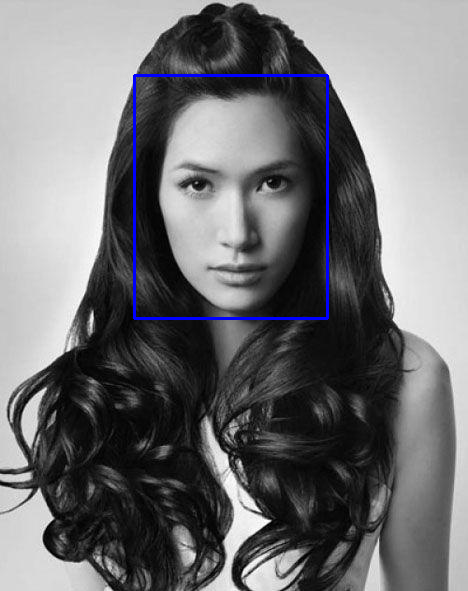

In [12]:
# Here you can see an image of how the face detector works. The face in the blue
# rectangle is found by the openCV model. 
faces = face_cascade.detectMultiScale(grey_pic_np)

for (x, y, w, h) in faces:
    cv.rectangle(grey_pic_np, (x, y - 35), (x+w, y+h + 15), (255, 0, 0), 2)

cv2_imshow(grey_pic_np)

In [13]:
class FaceshapesWithFaceDetection(Dataset):
    """Faceshapes dataset."""

    def __init__(self, images, target_str2int = target_str2int, transform=None):
        # list with all the image paths
        self.images = images 
        # mapping of target as string to int
        self.target_str2int = target_str2int
        # transformations that will be used on 
        self.transform = transform
        self.resizer = Resize((250, 250))
        self.to_pil = ToPILImage()

    def __len__(self):
      """This method returns the length of the dataset"""
      return len(self.images)

    def __getitem__(self, idx):
      """This method returns the image at index idx in the dataset after 
      applying transforms."""
      if torch.is_tensor(idx):
          idx = idx.tolist()

      img_name = self.images[idx]
      # the image is loaded 
      image = io.imread(img_name)
      
      # the image is resized to (250, 250) so that when the image is cropped
      # to just contain the face it will work the same on all the images
      image = self.resizer(self.to_pil(image))
      img_gray = gs(image)
      grey_pic_np = np.array(img_gray)

      faces = face_cascade.detectMultiScale(grey_pic_np)
      
      # thise is where the image is cropped
      for (x, y, w, h) in faces:
        crop_rectangle = (x, y - 5, x+w, y+h + 15)
        image = image.crop(crop_rectangle)

      # retrieving the target and encoding it as an integer
      shape = img_name.split("/")[1]
      shape_int = self.target_str2int[shape]
      # returns the sample as Dict[str, Any]
      sample = {'image': image, 'shape': shape_int}

      if self.transform:
          sample["image"] = self.transform(image)

      return sample

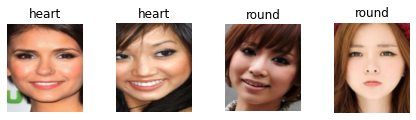

In [15]:
# Plotting test images as grid after extracting just the face from the image
test_grid_faces = FaceshapesWithFaceDetection(test_imgs)

fig = plt.figure()
random_indices = random.sample(range(0, len(test_grid_faces)), 4)

for i, idx in enumerate(random_indices):
    sample = test_grid_faces[idx]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.axis('off')

    plt.imshow(sample["image"])
    plt.title(target_int2str[sample["shape"]])

    if i == 3:
        plt.show()
        break

In [16]:
# These datasets and dataloaders are similair to the ones used in the first
# cnn model. The main difference is that there is no random crop of the images
# and the size of the images are slightly larger. 
test_cnn = FaceshapesWithFaceDetection(
  test_imgs,
  transform = transforms.Compose(
    [
      Resize((250, 250)),
      ToTensor()
    ]
  )
)

train_cnn = FaceshapesWithFaceDetection(
  train_imgs,
  transform = transforms.Compose(
    [
      Resize((250, 250)),
      ToTensor()
    ]
  )
)

test_dl_cnn = DataLoader(
    test_cnn, batch_size=len(test_imgs),
    shuffle=False, num_workers=0
)

train_dl_cnn = DataLoader(
    train_cnn, batch_size=24,
    shuffle=True, num_workers=0
)

In [17]:
# this model is pretty much the same as the first cnn model, the difference is
# that last linear layer have more input nodes as the images are slightly larger. 
class CNNFaceDetection(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.flatten = nn.Flatten()

    self.conv = nn.Sequential(
        nn.Conv2d(
            in_channels = 3,
            out_channels = 32,
            kernel_size = (6,6)
        ), 
        nn.ReLU(),

        nn.MaxPool2d((2,2)), 

        nn.Conv2d(
            in_channels = 32, 
            out_channels = 16, 
            kernel_size = (6,6)
        ),
        
        nn.ReLU(),
    )

    self.linear = nn.Sequential(
        nn.Linear(
            in_features = 219024,
            out_features = 5,
        )
    )

  def forward(self, x):
    x = self.conv(x)
    x = self.flatten(x)
    logits = self.linear(x)
    return logits

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = CNNFaceDetection().to(device)

Using cuda device


In [19]:
learning_rate = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 30

In [20]:
torch.cuda.empty_cache()

In [21]:
model, loss_history, val_history_train, val_history = training_loop(
    model, train_dl_cnn, test_dl_cnn, epochs, 
    loss_fn, optimizer, scheduler = None
)

Epoch 1/30
----------
Training loss: 1.5845 Acc: 0.2665
Eval Acc: 0.2750

Epoch 2/30
----------
Training loss: 1.4062 Acc: 0.3809
Eval Acc: 0.3950

Epoch 3/30
----------
Training loss: 1.2266 Acc: 0.5031
Eval Acc: 0.3800

Epoch 4/30
----------
Training loss: 1.0098 Acc: 0.6223
Eval Acc: 0.3900

Epoch 5/30
----------
Training loss: 0.8019 Acc: 0.7210
Eval Acc: 0.4200

Epoch 6/30
----------
Training loss: 0.6265 Acc: 0.7853
Eval Acc: 0.3750

Epoch 7/30
----------
Training loss: 0.4767 Acc: 0.8636
Eval Acc: 0.4400

Epoch 8/30
----------
Training loss: 0.3794 Acc: 0.8793
Eval Acc: 0.4500

Epoch 9/30
----------
Training loss: 0.2657 Acc: 0.9248
Eval Acc: 0.4400

Epoch 10/30
----------
Training loss: 0.2190 Acc: 0.9295
Eval Acc: 0.4300

Epoch 11/30
----------
Training loss: 0.1826 Acc: 0.9279
Eval Acc: 0.4600

Epoch 12/30
----------
Training loss: 0.1726 Acc: 0.9310
Eval Acc: 0.4750

Epoch 13/30
----------
Training loss: 0.1553 Acc: 0.9326
Eval Acc: 0.4350

Epoch 14/30
----------
Training lo

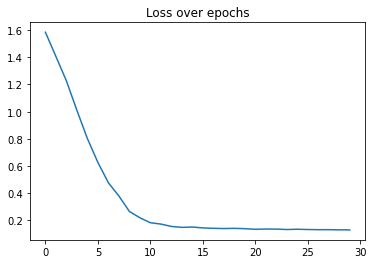

In [22]:
plt.title("Loss over epochs")
plt.plot(loss_history)
plt.show()

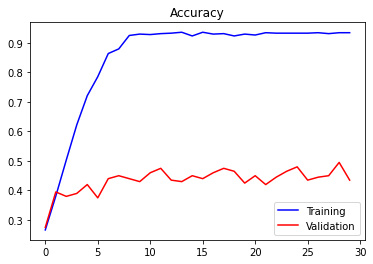

In [23]:
plt.title("Accuracy")
plt.plot([v.cpu() for v in val_history_train], c="b", label="Training")
plt.plot([v.cpu() for v in val_history], c="r", label="Validation")
plt.legend()
plt.show()

### __Resources:__




https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://towardsdatascience.com4-pre-trained-cnn-models-to-use-for-computer-vision-with-transfer-learning-885cb1b2dfc

https://arxiv.org/pdf/1911.07916.pdf

https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn
